# Data Augmentation - MNIST Dataset

Every time we train a classification model the amount of data we have is limited (even if that number reaches millions of instances). This supposes a problem, because the amount of data and its nature might not be enough to properly generalize the features of the classes to learn. Minor changes might lead the model to fail.

To prove that this is a real effect, a model will be trained and the accuracy tested, and then we will perform *data augmentation* on the test set. This technique is based on adding noise and/or arbitrary translations/rotations to the original dataset. If our assumption is true, the trained model should give lower accuracies, proving the importance of data augmentation during training.

### Table of Contents
- [0. Loading the Dataset](#0.-Loading-the-Dataset)
- [1. Training a Simple Model](#1.-Training-a-Simple-Model)
- [2. Data Augmentation](#2.-Data-Augmentation)
- [3. Visualization of Data Augmentation](#3.-Visualization-of-Data-Augmentation)
- [4. Testing the New Accuracies](#4.-Testing-the-New-Accuracies)

## 0. Loading the Dataset

In [1]:
import numpy as np
import scipy as sc
import sklearn as sk
import pandas  as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy.random

from scipy.ndimage import shift
from scipy.ndimage import rotate

import tensorflow as tf
from tensorflow.keras.layers     import Dense
from tensorflow.keras.utils      import to_categorical
from tensorflow.keras.optimizers import SGD

from sklearn.model_selection import train_test_split

In [2]:
mnist = pd.read_csv("Datasets/MNIST.csv", header=None)
mnist = np.array(mnist)

X = mnist[:,1:] / 255   # Normalizing our data
Y = mnist[:,0]          
oneY = to_categorical(Y)

#Generate train/test
X_train, X_test, Y_train, Y_test = train_test_split(X, oneY, train_size=0.7, test_size=0.3)

## 1. Training a Simple Model

We train a simple MLP with SGD optimizer. We get an accuracy of 95%. Until now, nothing new or surprising.

In [3]:
model = tf.keras.Sequential()

# Adds a densely-connected layer with 64 units to the model:
model.add(Dense(128, activation='relu'))
# Add another:
model.add(Dense(64,  activation='relu'))
# Add another:
model.add(Dense(32,  activation='relu'))
# Add a softmax layer with 10 output units:
model.add(Dense(10, activation='softmax'))

# Configure a model for mean-squared error regression.
model.compile(optimizer=SGD(lr=0.05),
              loss='categorical_crossentropy',   # mean squared error
              metrics=['acc'])                   # mean absolute error


arr = model.fit(X_train, Y_train, verbose=0, epochs=10)
score = model.evaluate(X_test, Y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1],'\n')

Test loss: 0.14509931170692048
Test accuracy: 0.9591666666666666 



## 2. Data Augmentation

Now the data augmentation is performed. Three different changes will be implemented:
- Translation
- Rotation
- Noise


In [4]:
# Translation
def traslate_imgs(X):
  # Final matrix
  trasl_X = np.zeros(X.shape)
  for ix, x in enumerate(X):
    # Vector of pixels to Matrix
    rx = x.reshape(28, 28)
    # How much shift in x and y?
    shift_x = np.random.randint(14) - 7
    shift_y = np.random.randint(14) - 7
    # Translate
    trasl_X[ix] = shift(x.reshape(28, 28), (shift_x, shift_y)).flatten()
  return trasl_X

# Rotation
def rotate_imgs(X):
  # Final matrix
  rot_X = np.zeros(X.shape)  
  for ix, x in enumerate(X):
    # Vector of pixels to Matrix
    rx = x.reshape(28, 28)
    # Choose random angle
    angle = np.random.randint(180) - 90
    # Rotate
    rot_X[ix] = rotate(x.reshape(28, 28), angle, reshape=False).flatten()
  return rot_X

# Noise
def noise_imgs(X, noise_level=0.5):
  # Final matrix
  nois_X = np.zeros(X.shape)
  for ix, x in enumerate(X):
    # Vector of pixels to Matrix
    rx = x.reshape(28, 28)
    # Noise level
    noise = (np.random.random(X[ix].shape) * 2 - 1) * noise_level
    # Add Noise
    nois_X[ix] = np.clip(x + noise, 0.0, 1.0).flatten()
  return nois_X

## 3. Visualization of Data Augmentation

In [9]:
# Generamos validación trasladada.
trasX_test = traslate_imgs(X_test)
# Generamos validación rotada.
rotaX_test = rotate_imgs(X_test)
# Generamos validación con ruido 50%.
no50X_test = noise_imgs(X_test, 0.5)
# Generamos validación con ruido 25%.
no25X_test = noise_imgs(X_test, 0.25)

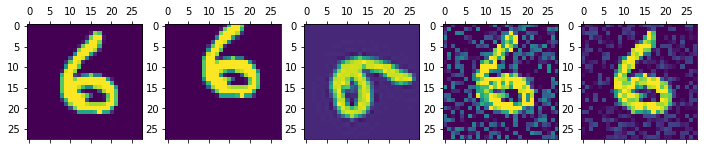

In [10]:
idx = 0

fig, axs = plt.subplots(1,5,figsize=(12,12))
axs[0].matshow(X_test[idx,:].reshape(28, 28))
axs[1].matshow(trasX_test[idx,:].reshape(28, 28))
axs[2].matshow(rotaX_test[idx,:].reshape(28, 28))
axs[3].matshow(no50X_test[idx,:].reshape(28, 28))
axs[4].matshow(no25X_test[idx,:].reshape(28, 28))
plt.show()

## 4. Testing the New Accuracies

In [7]:
# Generamos validación trasladada.
trasX_test = traslate_imgs(X_test)
# Generamos validación rotada.
rotaX_test = rotate_imgs(X_test)
# Generamos validación con ruido 50%.
no50X_test = noise_imgs(X_test, 0.5)
# Generamos validación con ruido 25%.
no25X_test = noise_imgs(X_test, 0.25)

In [8]:
print("Accuracy datos normales:", model.evaluate(X_test,     Y_test, verbose=0)[1] * 100,"%")
print("Accuracy datos traslad.:", model.evaluate(trasX_test, Y_test, verbose=0)[1] * 100,"%")
print("Accuracy datos rotation:", model.evaluate(rotaX_test, Y_test, verbose=0)[1] * 100,"%")
print("Accuracy datos noise50%:", model.evaluate(no50X_test, Y_test, verbose=0)[1] * 100,"%")
print("Accuracy datos noise25%:", model.evaluate(no25X_test, Y_test, verbose=0)[1] * 100,"%")

Accuracy datos normales: 95.91666666666666 %
Accuracy datos traslad.: 20.283333333333335 %
Accuracy datos rotation: 46.400000000000006 %
Accuracy datos noise50%: 81.6 %
Accuracy datos noise25%: 94.68333333333334 %


As it can be seen, the accuracies fall dramatically except for the low noise case (which it reasonable). This proves that data augmentation might be necessary if we want to properly generalize our model.